In [1]:
__author__ = 'Leah Fulmer, NOAO Data Lab Team'
__version__ = '20190103' # yyyymmdd
__datasets__ = ['gaia_dr2']  # enter used datasets by hand;
__keywords__ = ['star clusters','stars','proper motions','parallax','plot:cmd','plot:quiver','plot:animation']

# Visualizing Star Clusters in Gaia DR2
*Leah Fulmer and the NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Setting Up a Basic Query](#query)
* [Stationary Visualization](#stationary)
* [Parallax Animation](#animation)
* [Applying Both Visualizations](#both)

<a class="anchor" id="goals"></a>
# Goals
* Define a function that queries the Gaia DR2 catalog by star cluster name
* Visualize proper motions with a quiver plot
* Visualize parallax with animated plots

# Summary
This Notebook offers an example of a Cone Search query of the Gaia DR2 catalog. Given an object and a radius, this Notebook will query an area of the sky centered on the given object and extending out to the given radius. It will then offer several visualizations of the queried data.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports & Setup

In [2]:
# Imports for animation services
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation, matrix_utilities

from matplotlib import cm, colors, pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Imports from Data Lab notebook
from getpass import getpass

from dl.helpers.utils import convert
from dl import authClient as ac, queryClient as qc

%matplotlib inline

<a class="anchor" id="auth"></a>
# Authentication

In [3]:
# To save to virtual space, need to log in your account (not anonymous)
# token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))

<a class="anchor" id="query"></a>
# Setting Up a Basic Query

The database is called **gaia_dr2** and includes several tables. We explore the available tables below.

In [4]:
# Construct query as a string
query = "SELECT * FROM gaia_dr2.gaia_source LIMIT 1"

# Submit query
response = qc.query(sql=query, fmt='csv')

# Convert output string to to a pandas DataFrame
df_init = convert(response,'pandas')

# To view the available columns, include the following command
df_init.columns

Index(['solution_id', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'radius_val', 'radius_percentile_lower',
       'radius_percentile_upper', 'lum_val', 'lum_percentile_lower',
       'lum_percentile_upper', 'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_weight_al', 'astrometric_pseudo_colour',
       'astrometric_pseudo_colour_error', 'mean_varpi_factor_al',
       'astrometric_sigma5d_max', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error',
 

In [5]:
# Write a query that returns all of the stars surrounding a particular object out to a particular radius 

def input_query(object_name, radius_deg):
    # SkyCoord.from_name outputs the coordinates of a particular object given its name as a string
    c = SkyCoord.from_name(object_name)
    
    # Construct a Cone Search query
    query = """SELECT * FROM gaia_dr2.gaia_source 
            WHERE (q3c_radial_query(ra, dec, {0}, {1}, %s)
            AND NOT parallax='Nan')""".format(c.ra.value,c.dec.value) % (radius_deg)
    
    # Submit the query
    response = qc.query(sql=query, fmt='csv')
    
    # Convert the query to a pandas DataFrame
    df = convert(response,'pandas')
    
    # Check the number of objects in your query
    print("The query of %s contains %s objects." % (object_name, len(df)))
    
    # Return the output DataFrame
    return df

In [6]:
# Pick your favorite object!

# Define an object
object_queried = "NGC 6281"

# Define a radius
radius = 0.5

# Submit the function that returns a queried DataFrame
df = input_query(object_queried, radius)

The query of NGC 6281 contains 154854 objects.


In [7]:
# Define variables from DataFrame
# Doing so within a function makes later re-definition very simple
def define_variables (df):
    ra, dec = df["ra"], df["dec"]
    ra_rad, dec_rad = np.radians(ra), np.radians(dec)
    pmra, pmdec = df["pmra"], df["pmdec"]
    parallax = df['parallax']
    g, g_bp = df["phot_g_mean_mag"], df["phot_g_mean_mag"]-df["phot_bp_mean_mag"]
    return ra, dec, ra_rad, dec_rad, pmra, pmdec, parallax, g, g_bp

# Submit the function that defines variables from the DataFrame
ra, dec, ra_rad, dec_rad, pmra, pmdec, parallax, g, g_bp = define_variables(df)

<a class="anchor" id="stationary"></a>
# Stationary Visualization:

In [8]:
# Write a function that outputs spatial and color-color plots for your sampled object
def panel_plot(ra, dec, pmra, pmdec, color, mag):
    fig = plt.figure(figsize=(26,8))
    
    # A simple spatial plot
    ax1 = fig.add_subplot(131)
    ax1.scatter(ra, dec, marker='.', alpha= 1/np.power(len(df), 0.1))
    ax1.set_title("Spatial Plot",fontsize=10)
    ax1.set_xlabel("Right Ascension",fontsize=10)
    ax1.set_ylabel("Declination",fontsize=10)
    
    # A quiver plot (spatial plot with arrows that describe each object's proper motion)
    ax2 = fig.add_subplot(132)
    ax2.quiver(ra, dec, pmra, pmdec)
    ax2.set_title("Proper Motions",fontsize=10)
    ax2.set_xlabel("Right Ascension",fontsize=10)
    ax2.set_ylabel("Declination",fontsize=10)
    
    # A color-magnitude diagram that exhibits object density
    ax3 = fig.add_subplot(133)
    im3 = ax3.hexbin(g_bp, g, bins='log', cmap=plt.cm.viridis, mincnt=1)
    ax3.set_ylim(max(g), min(g))
    ax3.set_title("Color-Magnitude Diagram",fontsize=10)
    ax3.set_xlabel("Gaia G-BP Color",fontsize=10)
    ax3.set_ylabel("Gaia G Magnitude",fontsize=10)
    cb = plt.colorbar(im3,label='log(N)')

<a class="anchor" id="animation"></a>
# Parallax Animation:
Code based on that of Eric Tollerud via http://nbviewer.jupyter.org/gist/eteq/02a0065f15da3b3d8c2a9dea146a2a14/parallax_GaiaDR2.ipynb

Inspired by James Davenport via https://twitter.com/jradavenport/status/976205932274245632

In [9]:
# Convert variables to SkyCoord object and impose limits on output

def convert_to_skycoord (g, ra_rad, dec_rad, parallax, dist1, dist2):
    # Define variables as as an numpy array and SkyCoord object
    # Note: The SkyCoord object contains data for ra, dec, and parallax
    mag = np.array(g)
    scnow = SkyCoord(np.array(ra_rad) * u.rad, np.array(dec_rad) * u.rad, 
                 distance=(np.array(parallax)*u.mas).to(u.pc, u.parallax()))

    # Create a "mask" with varying data thresholds (here depending on magnitude and distance)
    msk = (mag < 16)  & (scnow.distance > dist1*u.pc) & (scnow.distance < dist2*u.pc)
    
    # Apply data thresholds to the given magnitude and SkyCoord objects
    mag = mag[msk]
    scnow = scnow[msk]
    
    # Print the new object count after applying data thresholds
    print('After the thresholds are applied, this query contains %s objects.' % (len(scnow)))
    
    # Return the defined variables
    return mag, msk, scnow
    
mag, msk, scnow = convert_to_skycoord(g, ra_rad, dec_rad, parallax, 1e2, 9e2)


After the thresholds are applied, this query contains 1108 objects.


In [10]:
# Make a special version of the viridis colormap that goes to a darker yellow at the end. 
# This makes it easier to see small points on a white background.
newvhsv = colors.rgb_to_hsv(cm.viridis.colors)
newvhsv[:,-1] = np.minimum(newvhsv[:,-1], .88)
darker_vidiris = colors.ListedColormap(colors.hsv_to_rgb(newvhsv))

# Define a function to represent magnitude with marker size and distance with marker color
# Here purple will symbolize closer object, and yellow will symbolize those further away
def mag_to_size(mag):
    unity_rescaled_mag = (np.max(mag) - mag)/np.ptp(mag)
    return 40*unity_rescaled_mag**2+2

# Save these visualization arguments as 'scatkwargs'
scatkwargs = dict(s=mag_to_size(mag), alpha=.9, c=scnow.distance, cmap=darker_vidiris)

In [11]:
# Write a function to animate the parallax of your sample

# The amplitude describes the distance that markers will move in portraying parallax.
amplitude = 0.6*u.lightyear
repr0 = scnow.barycentrictrueecliptic.cartesian

def animfunc(phase, eclcart_to_spherical, centerstr, ylims, ax):
    
    # Converting from cartesian to spherical coordiantes
    drepr = CartesianRepresentation([np.cos(phase),np.sin(phase),0]*amplitude)
    rep = repr0 + drepr
    srep = eclcart_to_spherical(rep)
    
    # Creating and defining plot aesthetics
    ax.cla()
    ax.set_title(f'Center={centerstr}, Earth Semimajor Axis={amplitude} \n')
    # ax.scatter(srep.lon.rad, 90-srep.lat.deg, **scatkwargs)
    ax.scatter(80.2+srep.lon.rad, 90-srep.lat.deg, **scatkwargs)
    ax.set_ylim(*ylims)
    ax.set_yticks(np.linspace(*ax.get_ylim(), 5)[1:])
    ax.set_yticklabels(['{}'.format(int(90-yl)) for yl in ax.get_yticks()])
    ax.grid(alpha=0.5)

In [12]:
# Centering the visualization on a given object
def eclcart_to_spherical3(rep):
    icrsrep = SkyCoord(scnow.barycentrictrueecliptic.realize_frame(rep)).icrs.cartesian   
    rot1 = matrix_utilities.rotation_matrix(object_name.ra, 'z')
    rot2 = matrix_utilities.rotation_matrix(90*u.deg-object_name.dec, 'y')
    return icrsrep.transform(rot2 @ rot1).represent_as(SphericalRepresentation)

<a class="anchor" id="both"></a>
# Applying Both Visualizations:

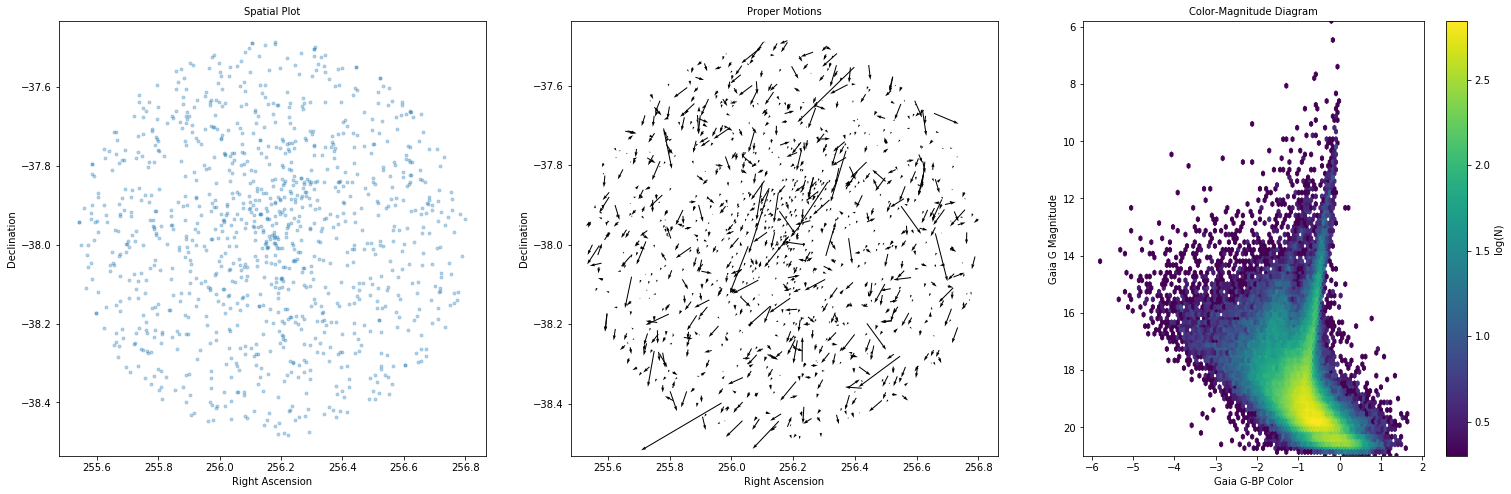

In [13]:
# Call stationary plot
panel_plot(scnow.ra, scnow.dec, pmra[msk], pmdec[msk], g_bp[msk], g[msk])

In [14]:
# Call parallax animation
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')
object_name = SkyCoord.from_name(object_queried)
centerstr3 = object_queried
ylims3 = (0, radius)

anim3 = animation.FuncAnimation(fig, animfunc, np.linspace(0, 2*np.pi, 30),
                                fargs=(eclcart_to_spherical3, centerstr3, ylims3, ax), 
                                interval=50)

plt.close(fig)
HTML(anim3.to_html5_video())

In [15]:
# Pick your second-favorite object!

# Define object and radius
object_queried = "NGC 6397"
radius = 0.1

# Submit query
df = input_query(object_queried, radius)

The query of NGC 6397 contains 16364 objects.


In [16]:
# Define variables
ra, dec, ra_rad, dec_rad, pmra, pmdec, parallax, g, g_bp = define_variables(df)

# Apply thresholds
mag, msk, scnow = convert_to_skycoord(g, ra_rad, dec_rad, parallax, 1e3, 3e3)

# Define visualization parameters
scatkwargs = dict(s=mag_to_size(mag), alpha=.9, c=scnow.distance, cmap=darker_vidiris)
amplitude = 0.6*u.lightyear
repr0 = scnow.barycentrictrueecliptic.cartesian

After the thresholds are applied, this query contains 721 objects.


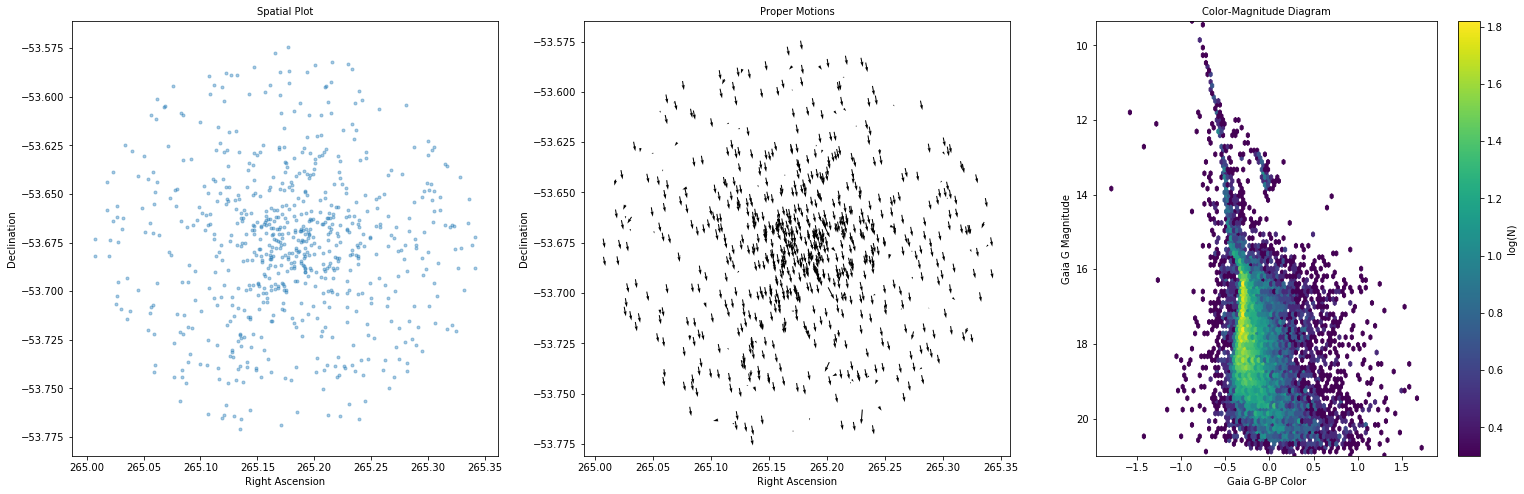

In [17]:
# Call stationary plot
panel_plot(scnow.ra, scnow.dec, pmra[msk], pmdec[msk], g_bp[msk], g[msk])

In [18]:
# Call parallax animation
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')
object_name = SkyCoord.from_name(object_queried)
centerstr3 = object_queried
ylims3 = (0, radius)

anim3 = animation.FuncAnimation(fig, animfunc, np.linspace(0, 2*np.pi, 30),
                                fargs=(eclcart_to_spherical3, centerstr3, ylims3, ax), 
                                interval=50)

plt.close(fig)
HTML(anim3.to_html5_video())